In [1]:
import torch
import os
import random
import numpy as np
import pytorch_lightning as pl

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from dataset.utils import process_classification_dataset, load_classification_dataset

config = {
        'dataset': 'facebook_ct1', # 'infectious_ct1', #
        'hidden_size': 32,
        'rnn_layers': 8,
        'readout_layers': 3,
        'cell_type': 'lstm',
        'dim_red': 64,
        'add_self_loops': False,
        'verbose': True,
        'cat_states_layers': True,
        'weight_decay': 1e-3,
        'step_size': 30,
        'gamma': 0.5
        }

# Select one GPU if more are available
os.environ["CUDA_VISIBLE_DEVICES"]='0'

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(seed)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Seed set to 42


In [2]:
# Fix cuda memory issue
dataset, states, node_states, node_labels = process_classification_dataset(config, "DynCRNN", device)

100%|██████████| 995/995 [11:29<00:00,  1.44it/s]


In [3]:
edge_indexes, _, _ = load_classification_dataset(config['dataset'], False)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

inputs, test_inputs, labels, test_labels = train_test_split(states.inputs[:,-1,:], dataset.targets, test_size=0.2, random_state=seed)

# Create the classifier
classifier = LogisticRegression(max_iter=5000, random_state=seed)

# Train the classifier
classifier.fit(inputs, labels)

# Test the classifier
y_pred = classifier.predict(test_inputs)

accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9547738693467337


# PCA per node

In [5]:
from torch_sparse import SparseTensor

idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

num_nodes = edge_index.max().item() + 1
adj_matrix = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(num_nodes, num_nodes))
adj_matrix = adj_matrix.to_dense()

In [6]:
from sklearn.decomposition import PCA
from einops import rearrange

node_states = rearrange(node_states[idx], 't n f -> n t f')

pca = PCA(n_components=10)
X = pca.fit_transform(rearrange(node_states, 'n t f -> (n t) f'))
X = rearrange(X, '(n t) f -> n t f', n=num_nodes, t=node_states.shape[1], f=10)
X = torch.from_numpy(X)

In [7]:
X.shape

torch.Size([100, 106, 10])

In [8]:
torch.nonzero(adj_matrix).size(0)

210

In [9]:
from DMD.sindy import sindy_library_adj

s = sindy_library_adj(X, adj_matrix)

In [30]:
X.shape

torch.Size([100, 106, 10])

In [10]:
s.shape

torch.Size([310, 106, 10])

In [31]:
from DMD.sindy import sindy_fit2

# s = rearrange(s, 'n t f -> (t n) f', n=s.shape[0], t=s.shape[1], f=10)

x = rearrange(s[:,:-1,:], 'n t f -> t (n f)')
y = rearrange(s[:num_nodes,1:,:], 'n t f -> t (n f)')

K = sindy_fit2(x, y, 1.0)

In [32]:
K.shape

(1000, 3100)

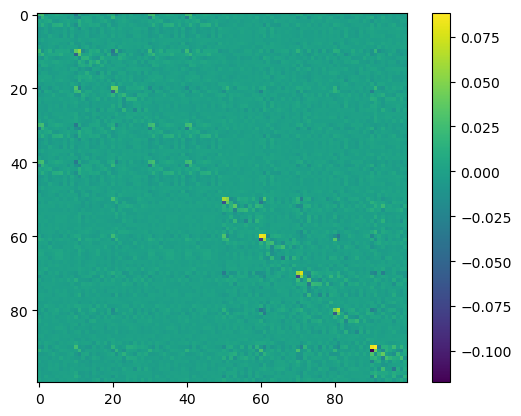

In [35]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(K[:100,:100])
plt.colorbar()
plt.show()

In [54]:
K.shape

(1000, 3100)

In [58]:
# Reshape K into a 3D array with shape (num_blocks, 10, num_features)
num_blocks = K.shape[0] // 10
sum_K = np.array([np.sum(K[i*10:(i+1)*10], axis=0) for i in range(num_blocks)])

num_blocks = K.shape[1] // 10
sum_K = np.stack([np.sum(sum_K[:,i*10:(i+1)*10], axis=1) for i in range(num_blocks)], axis=1)
# K_reshaped = rearrange(K, '(n f) H -> n f H', n=num_nodes, f=10)

# sum_K = np.sum(K_reshaped, axis=1)

In [59]:
sum_K.shape

(100, 310)

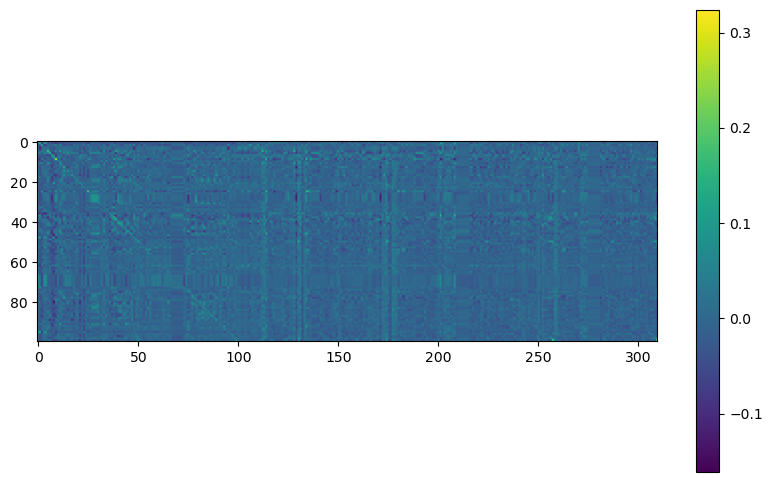

In [61]:
plt.figure(figsize=(10, 6))

plt.imshow(sum_K)
plt.colorbar()
plt.show()

In [89]:
weights = sum_K[:,100:].sum(axis=0)

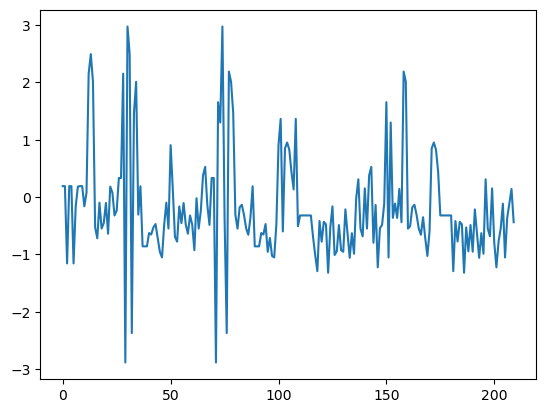

In [90]:
plt.plot(weights)

In [66]:
weights.shape

(210,)

In [78]:
idx = 0

edge_index = torch.cat(edge_indexes[idx], dim=1)
edge_index = torch.unique(edge_index.T, dim=0).T

In [97]:
edge_index.shape

torch.Size([2, 210])

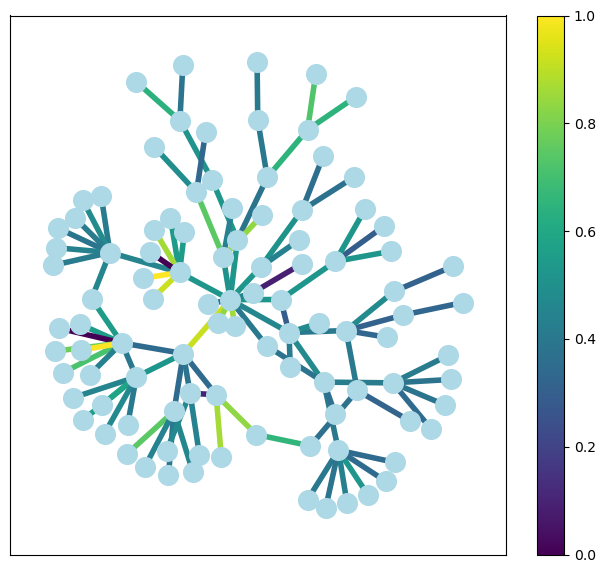

In [102]:
import networkx as nx

import matplotlib.pyplot as plt

# Create an empty graph
plt.figure(figsize=(8, 7))
G = nx.Graph()

# Add edges
G.add_edges_from(edge_index.T.tolist())

# Plot the graph
pos = nx.kamada_kawai_layout(G)
cmap = matplotlib.colormaps.get_cmap('viridis')
norm = plt.Normalize(min(weights), max(weights))
colors = [cmap(norm(w)) for w in weights]
# im = nx.draw(G, pos=pos, node_color='lightblue', edge_color=colors, width=2)
pax = nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=4)

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
# sm._A = []
plt.colorbar(pax)

# Show the plot
plt.show()

In [ ]:
E, V = np.linalg.eig(K)

# sort eigenvalues and eigenvectors
idx = np.argsort(np.abs(E))[::-1]
E = E[idx]
V = V[:, idx]

cmap = matplotlib.colormaps.get_cmap('viridis')

plt.figure(figsize=(5,5))
plt.scatter(E.real, E.imag, c=idx, cmap=cmap)
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_patch(circle)
plt.ylabel('Imaginary') 
plt.xlabel('Real')
plt.show()

In [27]:
(np.abs(E)>0.9).sum()

98